In [128]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [129]:
import numpy as np
import pickle
from load_5hot import load
from accuracy_calculations import acc_sequences_correct, calcError
from onehot_tostring import convert_to_nucs, convert_to_hardmax, show_noise
from keras import layers
from keras import callbacks
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv1D, Add, Reshape
from keras.layers import AveragePooling2D, UpSampling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import keras.backend as K
from keras.layers.core import Lambda
from keras.models import Model
import matplotlib.pyplot as plt
import datetime
from keras.activations import softmax

K.set_image_data_format('channels_last')
print('Done')

Done


In [130]:
[X_train,Y_train,X_test,Y_test,X_val,Y_val] = load("blast_tab_1hit.out")

Loading Data...
136465 sequences were uploaded

Maximum sequence length in is 308
Maximum sequence length out is 308

Converting to one-hot...
Done
Converting to one-hot...
Done
Converting to one-hot...
Done


In [132]:
m = X_train.shape[0]
print("There are " + str(m) + " training examples")
print("There are " + str(X_val.shape[0]) + " validation examples")
print("There are " + str(X_test.shape[0]) + " testing examples")
print("There are " + str(X_train.shape[1]) + " classes: A, C, G, T, -")
max_length = max(X_train.shape[2],X_test.shape[2])
print("The longest sequence is " + str(max_length) + " nucleotides long")
print("X_train shape is:")
print(X_train.shape)

There are 112089 training examples
There are 12269 validation examples
There are 12107 testing examples
There are 5 classes: A, C, G, T, -
The longest sequence is 308 nucleotides long
X_train shape is:
(112089, 5, 308, 1)


In [133]:
# Visualize data sets to ensure they appear as anticipated
def display_example_sequences(X,Y,n):
    for sample in range(n):
        samp_n_X = convert_to_nucs(X[sample,:,:,0])
        samp_n_Y = convert_to_nucs(Y[sample,:,:,0])
        print(samp_n_X + ', ' + samp_n_Y + '\n')

    print('')
    
n_examples = 3
print('\nTraining Examples:\n')
display_example_sequences(X_train,Y_train,n_examples)
print('\nValidation Examples:\n')
display_example_sequences(X_val,Y_val,n_examples)
print('\nTesting Examples:\n')
display_example_sequences(X_test,Y_test,n_examples)


Training Examples:

ACGGAGGGTGCGAGCGTTAATCGGAATCACTGGGCGTAAAGCGCACGTAGGCTGCTTGGTAAGTCAGGGGTGAAAGCCCGCGGCTCAACCGCGGAATTGCCTTTGATACTGC-CGAGCTAGAGTCCGGGAGAGGGTAGTGGAATTCCAGGTGTAGGAGTGAAATCCGTAGAGATCTGGAGGAACATCAGTGGCGAAGGCGACTACCTGGACCGGTACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAG--------------------------------------------------------, ACGGAGGGTGCAAGCGTTAATCGGAATCACTGGGCGTAAAGCGCACGTAGGCTGTTATGTAAGTCAGGGGTGAAAGCCCACGGCTCAACCGTGGAACTGCCCTTGATACTGCACGA-CTCGAATCCGGGAGAGGGTGGCGGAATTCCAGGTGTAGGAGTGAAATCCGTAGATATCTGGAGGAACATCAGTGGCGAAGGCGGCCACCTGGACCGGTATTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAG--------------------------------------------------------

ACAGAGGGGGCAAGCGTTGTCCGGAGTTACTGGGCGTAAAGGGCGCGCAGGCGGTGGGCTGCGTCGGCGCTGAAAGCGCCCCGCTTAACGGGGCGAGGCGCGCCGATACGAGTCCACTCGAGGCAAGCAGAGGGTGGCGGAATTCCGGGTGGAGTGGTGAAATGCGTAGAGATCCGGAGGAACGCCGGTGGGGAAGCCGGCCACCTGGGCTTGACCTGACGCTGCGGCGCGACAGCGTGGGGAGCAAACCG---------------------------------------------------------, ACAGAGGGGGCAAGCGTTGTCCGGAGTTACTGGGCGTAAAGGGCGCGCA

In [134]:
print('Permuting training samples...')
np.random.seed(0)
rand_perm = np.random.rand(m).argsort()
np.take(X_train,rand_perm,axis=0,out=X_train)
print("finished X")
np.take(Y_train,rand_perm,axis=0,out=Y_train)
print("finished Y")

Permuting training samples...
finished X
finished Y


In [137]:
def softMaxAxis1(x):
    return softmax(x,axis=1)

# started from: https://blog.sicara.com/keras-generative-adversarial-networks-image-deblurring-45e3ab6977b5
def Model_1(input_shape):
    """Build generator architecture."""
    # Current version : ResNet block
    X_input = Input(input_shape)

    X = Conv2D(128, (4, 7), strides = (1, 1), padding = 'same', name = 'conv0')(X_input)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(64, (1, 7), strides = (1, 1), padding = 'same', name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(64, (1, 7), strides = (1, 1), padding = 'same', name = 'conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    X = Dropout(0.3, name = 'dropout')(X)
   
    X = Conv2D(32, (1, 7), strides = (1, 1), padding = 'same', name = 'conv3')(X)
    X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(1, (1, 1), strides = (1, 1), padding = 'same', name = 'conv4')(X)
    X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Dense(1, activation = softMaxAxis1)(X)
    
    model = Model(inputs=X_input, outputs=X, name='Model_2')
    return model

In [138]:
myModel = Model_1((5,max_length,1))
print(myModel.summary())
print('Done!')
logging = []

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 5, 308, 1)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 5, 308, 128)       3712      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 5, 308, 128)       512       
_________________________________________________________________
activation_13 (Activation)   (None, 5, 308, 128)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 5, 308, 64)        57408     
_________________________________________________________________
bn1 (BatchNormalization)     (None, 5, 308, 64)        256       
_________________________________________________________________
activation_14 (Activation)   (None, 5, 308, 64)        0         
__________

In [139]:
myModel.compile(optimizer="Adam", loss="mean_squared_error", metrics = ["accuracy"])
print('Done!')

Done!


In [140]:
# Understand baseline accuracy of if model output its own input
diffs = np.absolute(X_train-Y_train);
err = np.sum(diffs)/np.ma.size(X_train);
print("Baseline accuracy of Train if predicting output = input is " + str(1-err))

diffs = np.absolute(X_val-Y_val);
err = np.sum(diffs)/np.ma.size(X_val);
print("Baseline accuracy of Val if predicting output = input is " + str(1-err))

diffs = np.absolute(X_test-Y_test);
err = np.sum(diffs)/np.ma.size(X_test);
print("Baseline accuracy of Test if predicting output = input is " + str(1-err))

Baseline accuracy of Train if predicting output = input is 0.9962580987070455
Baseline accuracy of Val if predicting output = input is 0.999137833394904
Baseline accuracy of Test if predicting output = input is 0.9990534616123119


In [141]:
class NBatchLogger(callbacks.Callback):
    """
    A Logger that log average performance per `display` steps.
    """
    def __init__(self, display):
        self.step = 0
        self.display = display
        self.losses = []
        self.accs = []

    def on_batch_end(self, batch, logs={}):
        self.step += 1
        if self.step % self.display == 0:
            loss = logs.get('loss')
            acc = logs.get('acc')
            self.losses.append(loss)
            self.accs.append(acc)
            print('\nstep {}: loss = {}, acc = {}'.format(self.step, loss, acc))

            
out_batch = NBatchLogger(display=500)
filepath="./convWeights/5hot-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=False, save_weights_only=True, mode='auto', period=1)
history = myModel.fit(x = X_train, y = Y_train, epochs = 15, validation_data = (X_val, Y_val), batch_size = 20, callbacks = [checkpoint, out_batch], verbose = 1)

loss_and_acc = myModel.evaluate(X_test, Y_test)
print(loss_and_acc)

currtime = datetime.datetime.now()
fname = "./convWeights/" + currtime.strftime("%m%d-%H%M") + "_5hot.hdf5"
print(fname)
myModel.save_weights(fname)
logging.append(out_batch)
histfname = "./trainHistoryDict_" + currtime.strftime("%m%d-%H%M") + "_5hot"
with open(histfname, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

Train on 112089 samples, validate on 12269 samples
Epoch 1/15
 10000/112089 [=>............................] - ETA: 1:22:49 - loss: 0.0138 - acc: 0.9970
step 500: loss = 0.008970940485596657, acc = 0.9993506669998169
 20000/112089 [====>.........................] - ETA: 1:13:41 - loss: 0.0115 - acc: 0.9978
step 1000: loss = 0.008429980836808681, acc = 0.9992207884788513
 30000/112089 [=======>......................] - ETA: 1:05:15 - loss: 0.0107 - acc: 0.9980
step 1500: loss = 0.008091369643807411, acc = 0.9994805455207825
 40000/112089 [=========>....................] - ETA: 57:08 - loss: 0.0102 - acc: 0.9982
step 2000: loss = 0.009490320459008217, acc = 0.9979870319366455
 50000/112089 [============>.................] - ETA: 49:08 - loss: 0.0099 - acc: 0.9984
step 2500: loss = 0.008477242663502693, acc = 0.9988961219787598
 60000/112089 [===============>..............] - ETA: 41:12 - loss: 0.0096 - acc: 0.9984
step 3000: loss = 0.009249147959053516, acc = 0.9981169104576111
 70000/11

 51600/112089 [============>.................] - ETA: 47:54 - loss: 0.0082 - acc: 0.9992
step 25000: loss = 0.0074874358251690865, acc = 0.9999350905418396
 61600/112089 [===============>..............] - ETA: 39:57 - loss: 0.0082 - acc: 0.9992
step 25500: loss = 0.007982796058058739, acc = 0.9994155764579773
 71600/112089 [==================>...........] - ETA: 32:01 - loss: 0.0082 - acc: 0.9992
step 26000: loss = 0.00786624662578106, acc = 0.9994805455207825
 81600/112089 [====================>.........] - ETA: 24:06 - loss: 0.0082 - acc: 0.9992
step 26500: loss = 0.008470971137285233, acc = 0.9989610314369202
 91600/112089 [=======================>......] - ETA: 16:11 - loss: 0.0082 - acc: 0.9992
step 27000: loss = 0.00864491332322359, acc = 0.9988636374473572
101600/112089 [==========================>...] - ETA: 8:17 - loss: 0.0082 - acc: 0.9992
step 27500: loss = 0.0075038098730146885, acc = 0.9998701214790344
111600/112089 [============================>.] - ETA: 23s - loss: 0.008

 12700/112089 [==>...........................] - ETA: 1:20:06 - loss: 0.0081 - acc: 0.9993
step 73500: loss = 0.008441214449703693, acc = 0.9989610314369202
 22700/112089 [=====>........................] - ETA: 1:12:06 - loss: 0.0081 - acc: 0.9993
step 74000: loss = 0.010890860110521317, acc = 0.996558427810669
 32700/112089 [=======>......................] - ETA: 1:03:58 - loss: 0.0081 - acc: 0.9993
step 74500: loss = 0.007427051663398743, acc = 1.0
 42700/112089 [==========>...................] - ETA: 56:10 - loss: 0.0081 - acc: 0.9993
step 75000: loss = 0.00752986827865243, acc = 0.9998701214790344
 52700/112089 [=============>................] - ETA: 48:14 - loss: 0.0081 - acc: 0.9993
step 75500: loss = 0.008868686854839325, acc = 0.998506486415863
 62700/112089 [===============>..............] - ETA: 40:09 - loss: 0.0081 - acc: 0.9993
step 76000: loss = 0.010740668512880802, acc = 0.9964285492897034
 72700/112089 [==================>...........] - ETA: 31:59 - loss: 0.0081 - acc: 

In [97]:
histfname = "./trainHistoryDict_" + "0603-0412" + "_5hot"
history = pickle.load(open(histfname, "rb" ))

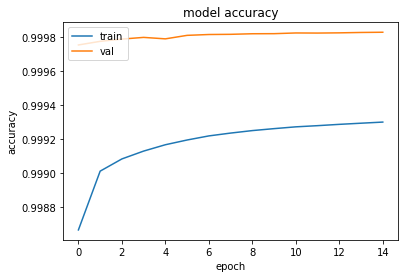

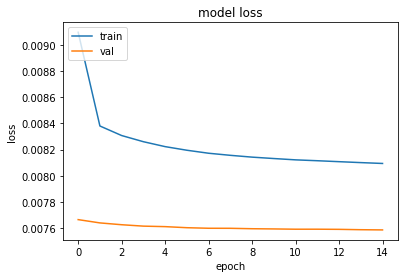

In [142]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [151]:
ii = 12
myModel.load_weights("./convWeights/everyepoch_pt9/5hot-{:02d}-1.00.hdf5".format(ii+1))
preds = myModel.predict(x = X_test)
print(preds[0,:,0:20,0])

[[1.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.    0.004
  1.    0.    0.    0.    0.    0.    0.999 0.   ]
 [0.    1.    0.004 0.    0.    0.    0.    0.    0.988 0.    1.    0.
  0.    0.    1.    0.    0.    0.    0.    0.998]
 [0.    0.    0.996 0.98  0.    1.    1.    0.999 0.001 1.    0.    0.995
  0.    1.    0.    1.    0.001 0.    0.    0.   ]
 [0.    0.    0.    0.019 0.    0.    0.    0.    0.01  0.    0.    0.
  0.    0.    0.    0.    0.999 0.999 0.001 0.002]
 [0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]]


In [150]:
# Show whole sequence
for n in range(100):
    print("Sample number " + str(n+1))
    samp_n_pred = preds[n,:,:,0]
    samp_n_in = X_test[n,:,:,0]
    samp_n_true = Y_test[n,:,:,0]

    samp_n_pred = convert_to_nucs(samp_n_pred)
    samp_n_true = convert_to_nucs(samp_n_true)
    samp_n_in = convert_to_nucs(samp_n_in)
    noisy = show_noise(samp_n_pred, samp_n_true, samp_n_in)

    print('Predicted:')
    print('Denoised:')
    print('Noisy:')
    print('Noise locations:\n')

    stt = 0
    stp = 100
    while(stp < len(noisy)):
        print(samp_n_pred[stt:stp])
        print(samp_n_true[stt:stp])
        print(samp_n_in[stt:stp])
        print(noisy[stt:stp])
        print('')
        stt = stp
        stp = stt+100



Sample number 1
Predicted:
Denoised:
Noisy:
Noise locations:

ACGGAGGGCGCGAGCGTTACCCGGATTCACTGGGCGTAAAGGGCGTGTAGGCGGCCTGGGGCGTCCCATGTGAAAGACCACGGCTCAACCGTGGGGGAGC
ACGGAGGGCGCGAGCGTTACCCGGATTCACTGGGCGTAAAGGGCGTGTAGGCGGCCTGGGGCGTCCCATGTGAAAGACCACGGCTCAACCGTGGGGGAGC
ACGGAGGGCGCGAGCGTTACCCGGATTCACTGGGCGTAAAGGGCGTGTAGGCGGCCTGGGGCGTCCCATGTGAAAGACCACGGCTCAACCGTGGGGGAGC
----------------------------------------------------------------------------------------------------

GTGGGATACGCTCAGGCTAGACGGTGGGAGAGGGTGGTGGAATTCCCGGAGTAGCGGTGAAATGCGCAGATACCGGGAGGAACGCCGATGGCGAAGGCAG
GTGGGATACGCTCAGGCTAGACGGTGGGAGAGGGTGGTGGAATTCCCGGAGTAGCGGTGAAATGCGCAGATACCGGGAGGAACGCCGATGGCGAAGGCAG
GTGGGATACGCTCAGGCTAGACGGTGGGAGAGGGTGGTGGAATTCCCGGAGTAGCGGTGAAATGCGCAGATACCGGGAGGAACGCCGATGGCGAAGGCAG
----------------------------------------------------------------------------------------------------

CCACCTGGTCCACCCGTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACCG-------------------------------------------------
CCACCTGGTCCACCCGTGACGCTGAGG

Predicted:
Denoised:
Noisy:
Noise locations:

ACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGTACGTAGGCGGATTGGAAAGTTGGGGGTGAAATCCCAGGGCTCAACCCTGGAACTGC
ACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGTACGTAGGCGGATTGGAAAGTTGGGGGTGAAATCCCAGGGCTCAACCCTGGAACTGC
ACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGTACGTAGGCGGATTGGAAAGTTGGGGGTGAAATCCCAGGGCTCAACCCTGGAACTGC
----------------------------------------------------------------------------------------------------

CTCCAAAACTATCAGTCTAGAGTTCGAGAGAGGTGAGTGGAATTCCAAGTGTAGAGGTGAAATTCGTAGATATTTGGAGGAACACCAGTGGCGAAGGCGG
CTCCAAAACTATCAGTCTAGAGTTCGAGAGAGGTGAGTGGAATTCCAAGTGTAGAGGTGAAATTCGTAGATATTTGGAGGAACACCAGTGGCGAAGGCGG
CTCCAAAACTATCAGTCTAGAGTTCGAGAGAGGTGAGTGGAATTCCAAGTGTAGAGGTGAAATTCGTAGATATTTGGAGGAACACCAGTGGCGAAGGCGG
----------------------------------------------------------------------------------------------------

CTCACTGGCTCGATACTGACGCTGAGGTACGAAAGTGTGGGGAGCAAACAG-------------------------------------------------
CTCACTGGCTCGATACTGACGCTGAGGTACGAAAGTGTGGGGA

In [143]:
# EVALUATE EVERY EPOCH
print("Accuracy of input is: " + str(acc_sequences_correct(X_test_conv,Y_test_conv)))
print('')

for ii in range(15):
    print('Epoch ' + str(ii))
    myModel.load_weights("./convWeights/5hot-{:02d}-1.00.hdf5".format(ii+1))
    preds = myModel.predict(x = X_test)

    # Change axes to match the sequential model
    X_test_conv = np.swapaxes(np.squeeze(X_test), 1, 2)
    Y_test_conv = np.swapaxes(np.squeeze(Y_test), 1, 2)
    preds_conv = np.swapaxes(np.squeeze(preds), 1, 2)
    # print(X_test_conv.shape)
    # print(Y_test_conv.shape)
    # print(preds_conv.shape)

    # Make sure everything is hardmax
    num_examples = preds_conv.shape[0]
    for n in range(num_examples):
        preds_conv[n,:,:] = np.swapaxes(convert_to_hardmax(preds[n,:,:,0]),0,1)
        if n < 0:
            print(np.swapaxes(preds[n,:,:,0],0,1))
            print(preds_conv[n,:,:])

    # Print out all metrics
    print("Using accuracy as number of completely correct (noiseless) sequences divided by total number of sequences:")
    print("Accuracy of model is: " + str(acc_sequences_correct(preds_conv,Y_test_conv)))
    [epb, eps] = calcError(preds_conv, Y_test_conv, X_test_conv, True)
    print('Error per base: ' + str(epb))
    print('Error per sequence: ' + str(eps))
    print('')

Accuracy of input is: 0.8755265548856034

Epoch 0
Using accuracy as number of completely correct (noiseless) sequences divided by total number of sequences:
Accuracy of model is: 0.9266540018171305
Baseline error(num mismatched nucleotides between target and input average per sequence): 0.7288345585198646
Prediction error(num mismatched nucleotides between target and prediction average per sequence): 0.20112331708928718
Average good changes per sequence : 0.5291979846369869
Average bad changes per sequence: 0.0014867432064095151
Average failure to change per sequence: 0.19963657388287767
Error per base: 0.0008015727284877302
Error per sequence: 0.20112331708928718

Epoch 1
Using accuracy as number of completely correct (noiseless) sequences divided by total number of sequences:
Accuracy of model is: 0.9368134137275956
Baseline error(num mismatched nucleotides between target and input average per sequence): 0.7288345585198646
Prediction error(num mismatched nucleotides between target an

Using accuracy as number of completely correct (noiseless) sequences divided by total number of sequences:
Accuracy of model is: 0.9645659535805732
Baseline error(num mismatched nucleotides between target and input average per sequence): 0.7288345585198646
Prediction error(num mismatched nucleotides between target and prediction average per sequence): 0.1439663004873214
Average good changes per sequence : 0.591558602461386
Average bad changes per sequence: 0.006690344428842818
Average failure to change per sequence: 0.13727595605847856
Error per base: 0.0005737746471269461
Error per sequence: 0.1439663004873214

Epoch 14
Using accuracy as number of completely correct (noiseless) sequences divided by total number of sequences:
Accuracy of model is: 0.9645659535805732
Baseline error(num mismatched nucleotides between target and input average per sequence): 0.7288345585198646
Prediction error(num mismatched nucleotides between target and prediction average per sequence): 0.142644750970512

In [155]:
# Change n to view the predictions, true sequence, and input sequence for a given sample
n = 77#  99, 87, 77
print("Sample number " + str(n+1))
samp_n_pred = preds[n,0:5,:,0]
samp_n_in = X_test[n,0:5,:,0]
samp_n_true = Y_test[n,0:5,:,0]

np.set_printoptions(precision=3, suppress=True)
noise = np.argmax(np.sum(np.square(samp_n_in - samp_n_true),axis=0))
print("The noise was at nucleotide number " + str(noise))
print("The predictions from " + str(noise-2) + " to " + str(noise+2) + " are: ")
print(preds[n,0:5,noise-2:noise+3,0])
print("The true denoised nucleotides from " + str(noise-2) + " to " + str(noise+2) + " are: ")
print(Y_test[n,0:5,noise-2:noise+3,0])
print("The input nucleotides from " + str(noise-2) + " to " + str(noise+2) + " were: ")
print(X_test[n,0:5,noise-2:noise+3,0])

Sample number 78
The noise was at nucleotide number 56
The predictions from 54 to 58 are: 
[[0.002 0.    0.002 0.205 0.   ]
 [0.001 0.    0.992 0.393 0.999]
 [0.    0.    0.001 0.    0.   ]
 [0.996 0.999 0.005 0.401 0.001]
 [0.    0.    0.    0.    0.   ]]
The true denoised nucleotides from 54 to 58 are: 
[[0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
The input nucleotides from 54 to 58 were: 
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0.]]
